# 세번째. Keras와 Tensorflow을 이용한 딥 러닝 예제 (Modeling the Final Energy Predictor by using Keras and Tensorflow)
<hr/>
## 예제 목표:
  이번 예제에서는 GPU Cluster를 사용해서 빠른 속도로 딥 러닝 연산을 처리하는 코드를 만들어본다. 이를 위해 Tensorflow를 backend로 사용하는 딥 러닝 라이브러리인 Keras[[3](https://keras.io)] 를 이용해서 쉽고 편리하게 예측 모델을 구성할 것이다. 두번째 예제와 마찬가지로, Materials Scientific Community에 기축되어 있는 Open Quantum Materials Database [[1]](http://dx.doi.org/10.1007/s11837-013-0755-4)[[2]](http://dx.doi.org/10.1038/npjcompumats.2015.10) ([OQMD](http://www.oqmd.org), NorthWestern Univ.)의 DFT 계산 데이터를 기반으로 화학론량적(Stoichiometric) 계산 값들을 추가한 Features들이 포함된 자료를 활용한다.
  
### Overview
  예제의 딥 러닝 학습은 크게 다음의 2가지 파트로 구성된다.
1. 데이터 로딩 및 전처리
2. 모델 생성 및 분석
<hr/>
###### Comments
 지난 예제에서 다루었던 기본적인 내용들은 주로 생략하거나 간단히 다루고, 새로 추가되거나 달라진 부분에 대하여 상세히 다룰 예정.

<hr/>
## 1. 데이터 로딩 및 전처리
  앞선 예제에서, 사용했던 학습용 데이터 파일을 동일하게 사용한다. 해당 파일은 Scientific Data Repository (SDR)의 데이터베이스에 등록되어 있으므로, Restful API를 사용해서 쉽게 다운로드/가공이 가능하다.
![fig_rest_api_download](./figures/restapidownload.jpg)
<center>[Restful ApI를 이용한 dataset 다운로드의 예]</center>

\[Command\]
curl -O 150.183.247.242:8080/rest/api/file/dataset/1246923/path/oqmd-complex-removedoutliers.csv [download](http://150.183.247.242:8080/rest/api/file/dataset/1246923/path/oqmd-complex-removedoutliers.csv)
<br>\[Format\] {sdr_server_address:port_number}/rest/api/file/dataset/{datasetId}/path/{filename}
<br>\[option\] -O: 서버에 위치한 파일명과 동일한 이름으로 다운로드

In [2]:
# 연산 시간 측정을 위한 time(), array 
import time
import numpy as np
import pandas as pd

주요 Keras 및 scikit-learn, 그리고 graph plotting 을 위한 pyplot 패키지를 import 한다.

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.models import load_model
from keras.models import model_from_json
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import adam
from keras import optimizers
from keras import regularizers

Using TensorFlow backend.


In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as calMAE
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline 

In [5]:
# import tensorflow for using gpu_options
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1, allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True, gpu_options=gpu_options))

In [6]:
########################################
## path settings #######################
########################################
#
# path setting
currentPath = "./"
dataPath = "data/"
figPath = ".figures/"
modelPath = "models/"
data_name = "final_energy_per_atom_"

GPU클러스터 자원을 활용함으로서 epochs 및 batch_size를 크게 증가시킬 수 있다.

In [19]:
########################################
## environment settings ################
########################################
#
seed = 7
# model training
training_epochs = 5
batch_size = 512
n_splits = 5
data_name = 'final'

Categorical infomation 인 Space Group 정보는 Binarizer하여 학습시킨다.

In [8]:
########################################
## data loading #####################
########################################
fileName = "oqmd-complex-removedoutliers.csv"
df = pd.read_csv(currentPath+dataPath+fileName)
df.fillna(0,inplace=True)


spacegroupnum_lb = LabelBinarizer()
spacegroupnum_lb = spacegroupnum_lb.fit_transform(df["spacegroupnum"])

dataset = df.values

Python 기반의 언어에서는 index number가 0에서 시작하므로 Final Energy/atom 을 선택하려면 column 2 가 선택되어야한다. 또한 학습 시간을 단축하고 효율적인 학습을 위해 scikit-learn의 StandardScaler()를 이용하여 학습 데이터를 표준화(Standarization)하였다.

In [10]:
starting_number_of_x_data = 5     # mass~
ending_number_of_x_data = df.shape[1]-1
pre_x = dataset[:,starting_number_of_x_data:ending_number_of_x_data]
t_pro = 'finalenergypa'
y = dataset[:,2]                  # final
before_scale_x = np.append(pre_x, spacegroupnum_lb, axis = 1)
scaler = StandardScaler()
scaled_x = scaler.fit_transform(before_scale_x)

In [14]:
pre_x.shape

(120497, 231)

In [20]:
########################################
## data splitting #####################
########################################
# seed shuffle
np.random.seed(seed)

x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.2, random_state=seed)
                                                    #, random_state=4567)

num_of_train_samples = x_train.shape[0]                     # Train Sample 수
num_of_train_features = x_train.shape[1]  

80% Training dataset, 20% Testing dataset 으로 랜덤하게 나뉘어졌음을 확인할 수 있다.

In [21]:
print(x_train.shape, x_test.shape)

(96397, 444) (24100, 444)


이전보다 더 깊은 네트워크를 구성할 수 있다. Kernel Initializer, Activation, Loss function, Optimizer, 또는 Metrics의 선택 및 그에 따른 상세한 옵션의 설정도 가능하다. 그리고 Custom function 을 지원하기 때문에 직접 구현하여 이를 대체할 수도 있다.

In [12]:
def create_network():
    model = Sequential()
    model.add(Dense(512, input_dim=num_of_train_features,kernel_initializer='lecun_normal', activation='relu'))
    model.add(Dense(512, kernel_initializer='lecun_normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='lecun_normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='lecun_normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='lecun_normal', activation='relu'))
    model.add(Dense(128, kernel_initializer='lecun_normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='lecun_normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='lecun_normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='lecun_normal'))
    model.compile(loss='mean_absolute_error',optimizer='adam', metrics=['mae'])
    return model

In [22]:
def create_network():
    model = Sequential()
    model.add(Dense(20, kernel_initializer='lecun_normal', activation='relu'))
    model.add(Dense(20, kernel_initializer='lecun_normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='lecun_normal'))
    model.compile(loss='mean_absolute_error',optimizer='adam', metrics=['mae'])
    return model

In [23]:
start_time = time.time()
estimator = KerasRegressor(build_fn=create_network, epochs = training_epochs, batch_size = batch_size, verbose=True)
np.random.seed(seed)
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
history = estimator.fit(x_train, y_train)
y_pred = estimator.predict(x_test)
perf=calMAE(y_pred,y_test)

Epoch 1/5
77117/77117 [==============================] - 1s 9us/step - loss: 2.2022 - mean_absolute_error: 2.2022
Epoch 2/5
77117/77117 [==============================] - 1s 8us/step - loss: 0.4192 - mean_absolute_error: 0.4192
Epoch 3/5
77117/77117 [==============================] - 1s 7us/step - loss: 0.3362 - mean_absolute_error: 0.3362
Epoch 4/5
77117/77117 [==============================] - 1s 8us/step - loss: 0.3050 - mean_absolute_error: 0.3050
Epoch 5/5
19280/19280 [==============================] - 0s 7us/step
Epoch 1/5
77117/77117 [==============================] - 1s 9us/step - loss: 1.7845 - mean_absolute_error: 1.7845
Epoch 2/5
77117/77117 [==============================] - 1s 7us/step - loss: 0.4101 - mean_absolute_error: 0.4101A: 0s - loss: 0.4511 - mean_absolute_error
Epoch 3/5
77117/77117 [==============================] - 1s 8us/step - loss: 0.3362 - mean_absolute_error: 0.3362
Epoch 4/5
77117/77117 [==============================] - 1s 7us/step - loss: 0.2971 - mean_

* 이번 학습에 소요된 시간은 약 2340초로, 40분 정도가 소요되었다. 소재의 구조 정보 없이도 0.1 MAE 정도의 높은 예측 정확도를 보였다. 파라미터를 최적화하고 학습시간을 크게 증가시켰을 때, 같은 조건으로 0.085 MAE 까지 성능이 향상될 수 있음을 확인하였다.

In [14]:
print("%.d-fold for training_datasets: mean-> %.2f std->%.2f (MAE)" % (n_splits, results.mean(), results.std()))
print("Accuracy calculation for testing_set(never learned) (MAE) = "+str(perf))

end_time=time.time()
print(end_time-start_time)

5-fold for training_datasets: mean-> 0.11 std->0.01 (MAE)
Accuracy calculation for testing_set(never learned) (MAE) = 0.104569492713
1291.8783175945282


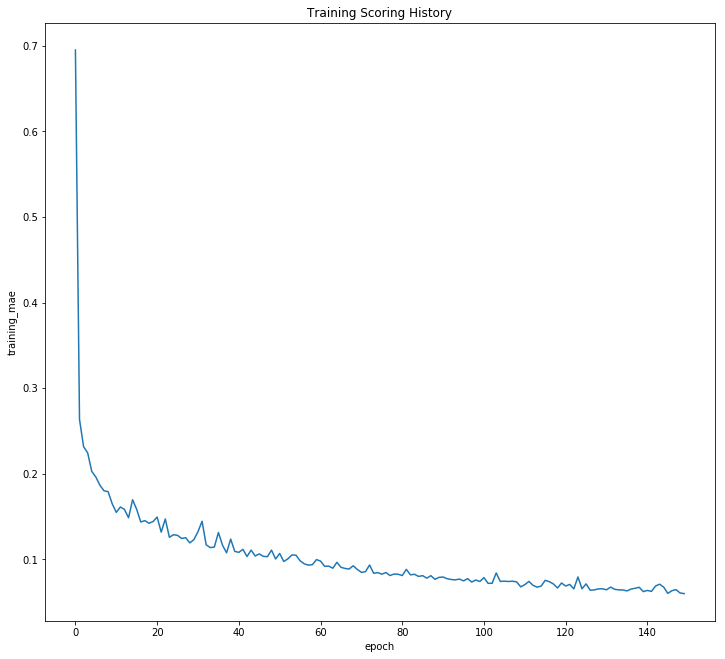

In [15]:
plt.rcParams['figure.figsize']=(12,11)
# summarize history for MAE
plt.plot(history.history['mean_absolute_error'])
plt.title('Training Scoring History')
plt.ylabel('training_mae')
plt.xlabel('epoch')
#plt.legend(['train'], loc='upper left')
plt.show()

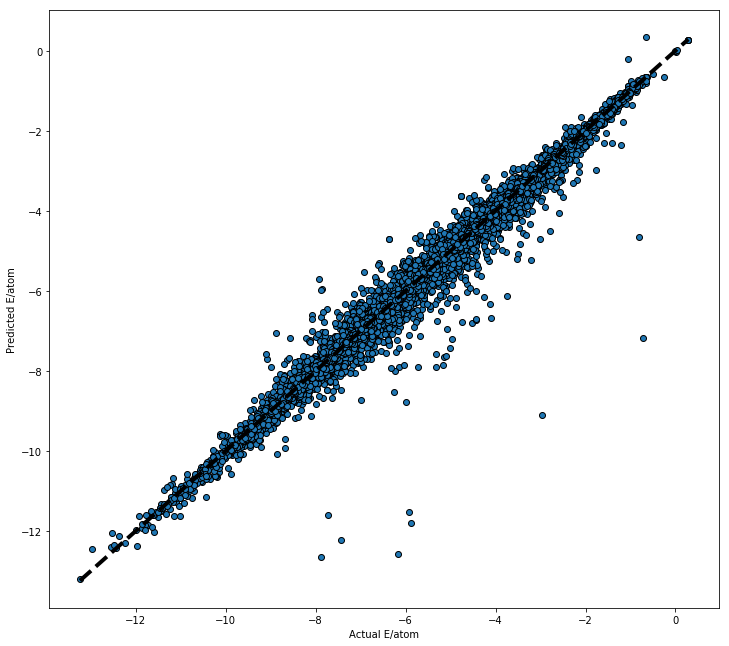

In [16]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual E/atom')
ax.set_ylabel('Predicted E/atom')
plt.show()

R과 마찬가지로, 손쉽게 모델을 저장하고 로드하여 재사용할 수 있다.

In [17]:
# https://keras.io/models/about-keras-models/
model_json = estimator.model.to_json()
with open(currentPath+modelPath+data_name+"savemodel-Keras.json","w") as json_file:
    json_file.write(model_json)
json_file.close()
#serialize weights to HDFS
estimator.model.save_weights(currentPath+modelPath+data_name+'savemodel-Keras.h5')
print("Saved model to disk")

Saved model to disk


In [18]:
# load json and create model
with open(currentPath+modelPath+data_name+"savemodel-Keras.json","r") as json_file:
    loaded_model_json_from_file = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json_from_file)
# load weights into new model
loaded_model.load_weights(currentPath+modelPath+data_name+'savemodel-Keras.h5')
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='mean_absolute_error',optimizer='adam', metrics=['mae'])
y_pred_loaded = loaded_model.predict(x_test)
perf=calMAE(y_pred_loaded,y_test)

print("Accuracy calculation for testing_set(never learned) (MAE) = "+str(perf))

Loaded model from disk
Accuracy calculation for testing_set(never learned) (MAE) = 0.104569492673


 GPU cluster를 이용할 때의 큰 장점은 한번에 많은 양의 학습을 수행할 수 있다는 점이다. 물론 batch size 가 지나치게 크고 epochs가 작다면 weight update 의 수가 너무 적어 예측 모델의 튜팅이 어려워진다. 하지만 데이터의 전체 모습에 가깝게 학습시키며 모델을 구성할 수 있다는 것은 Local minima 문제에서 빠져나오기 쉽기 때문에 너무나도 큰 장점이된다.
 
 지금까지 R과 Tensorflow를 이용하여 소재 데이터를 학습시키고 예측 모델을 생성하는 딥 러닝 기법의 예제들을 살펴보았다. 예제에서는 Final Energy/atom 만을 다루었지만, 그 외의 Label들의 경우는 어떨까? 예를 들어, Band gap 의 경우 예측 모델이 잘 작동할까?
 
 더 많은 데이터와 강력한 Feature, 반짝이는 아이디어와 직관, 그리고 끈기를 더하여 이와 같은 한층 심화된 문제들을 해결하는 성과가 있기를 바란다.
 
 <hr/>
###### References
[1] Saal, J. E., Kirklin, S., Aykol, M., Meredig, B., and Wolverton, C. "Materials Design and Discovery with High-Throughput Density Functional Theory: The Open Quantum Materials Database (OQMD)", JOM 65, 1501-1509 (2013). doi:10.1007/s11837-013-0755-4 [Link](http://dx.doi.org/10.1007/s11837-013-0755-4)

  [2] Kirklin, S., Saal, J.E., Meredig, B., Thompson, A., Doak, J.W., Aykol, M., Rühl, S. and Wolverton, C. "The Open Quantum Materials Database (OQMD): assessing the accuracy of DFT formation energies", npj Computational Materials 1, 15010 (2015). doi:10.1038/npjcompumats.2015.10 [Link](http://dx.doi.org/10.1038/npjcompumats.2015.10)
  
  [3] Keras: The Python Deep Learning library, web site, URL (https://keras.io)